<a href="https://colab.research.google.com/github/tuanymariiah/projeto_rossmam/blob/main/Projeto_Rossmam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importação das Bibliotecas


In [1]:
!pip install inflection
#!pip install BorutaPy

In [2]:
import pandas as pd
import numpy as np
import math
import inflection # biblioteca para renomear o nome das colunas
import seaborn as sns
import datetime

from matplotlib            import pyplot as plt
from scipy                 import stats  as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from IPython.display       import Image


#Funções

In [3]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

#Carrega Dataset

In [4]:
base_train = '/content/drive/MyDrive/Projetos Pessoais/comunidade ds/projeto rossmann/dataset/train.csv'
base_store = '/content/drive/MyDrive/Projetos Pessoais/comunidade ds/projeto rossmann/dataset/store.csv'
df_sales_raw = pd.read_csv(base_train, low_memory=False)
df_store_raw = pd.read_csv(base_store, low_memory=False)
# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')


# Descrição dos Dados

In [5]:
df1 = df_raw.copy()

##Dimensão dos Dados

In [6]:
print(f'Quantidade de Linhas {df1.shape[0]} e Quantidade de Colunas {df1.shape[1]}')

Quantidade de Linhas 308219 e Quantidade de Colunas 18


## Apresentação do Tipo dos Dados

In [7]:
df1.dtypes

Store                          int64
DayOfWeek                    float64
Date                          object
Sales                        float64
Customers                    float64
Open                         float64
Promo                        float64
StateHoliday                  object
SchoolHoliday                float64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [8]:
df1['Date'] = pd.to_datetime(df1['Date'])

##Quantidade de dados nulos

In [9]:
df1.isna().sum()

Store                             0
DayOfWeek                         1
Date                              1
Sales                             1
Customers                         1
Open                              1
Promo                             1
StateHoliday                      1
SchoolHoliday                     1
StoreType                         0
Assortment                        0
CompetitionDistance             790
CompetitionOpenSinceMonth     98017
CompetitionOpenSinceYear      98017
Promo2                            0
Promo2SinceWeek              155290
Promo2SinceYear              155290
PromoInterval                155290
dtype: int64

Tratamento dos dados faltantes

In [10]:
#CompetitionDistance
df1['CompetitionDistance'].fillna(200000.0, inplace = True)  #assumindo que uma distancia maior que a max, o competidor nao participou           
#CompetitionOpenSinceMonth
df1['CompetitionOpenSinceMonth'] = df1.apply( lambda x: x['Date'].month if math.isnan( x['CompetitionOpenSinceMonth'] ) else x['CompetitionOpenSinceMonth'], axis=1 )                             
#CompetitionOpenSinceYear
df1['CompetitionOpenSinceYear'] = df1.apply( lambda x: x['Date'].year if math.isnan( x['CompetitionOpenSinceYear'] ) else x['CompetitionOpenSinceYear'], axis=1 )                             
#Promo2SinceWeek 
df1['Promo2SinceWeek'] = df1.apply( lambda x: x['Date'].week if math.isnan( x['Promo2SinceWeek'] ) else x['Promo2SinceWeek'], axis=1 )                             
#Promo2SinceYear  
df1['Promo2SinceYear'] = df1.apply( lambda x: x['Date'].year if math.isnan( x['Promo2SinceYear'] ) else x['Promo2SinceYear'], axis=1 )                             
#PromoInterval   
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['PromoInterval'].fillna(0, inplace=True )
df1['month_map'] = df1['Date'].dt.month.map( month_map )
df1['is_promo'] = df1[['PromoInterval', 'month_map']].apply( lambda x: 0 if x['PromoInterval'] == 0 else 1 if x['month_map'] in x['PromoInterval'].split( ',' ) else 0, axis=1 )

df1.dropna(inplace=True)

mudando o tipo de algumas colunas

In [11]:
df1['CompetitionOpenSinceMonth'] = df1['CompetitionOpenSinceMonth'].astype(int)
df1['CompetitionOpenSinceYear'] = df1['CompetitionOpenSinceYear'].astype(int)

df1['Promo2SinceWeek'] = df1['Promo2SinceWeek'].astype(int)
df1['Promo2SinceYear'] = df1['Promo2SinceYear'].astype(int)


##Análise Estatísstica Descritiva*

- kurtosis
- skew

In [12]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'] )

# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Store,1.0,1115.0,1114.0,558.357198,558.0,321.831213,-0.000706,-1.200156
1,DayOfWeek,1.0,7.0,6.0,4.003618,4.0,1.994167,-0.004986,-1.241098
2,Sales,0.0,41551.0,41551.0,5993.145994,6000.0,3961.418488,0.568196,1.519275
3,Customers,0.0,5458.0,5458.0,637.858577,617.0,466.406418,1.599578,7.138470
4,Open,0.0,1.0,1.0,0.828446,1.0,0.376992,-1.742464,1.036187
5,Promo,0.0,1.0,1.0,0.398500,0.0,0.489589,0.414633,-1.828091
6,SchoolHoliday,0.0,1.0,1.0,0.158339,0.0,0.365059,1.871821,1.503725
7,CompetitionDistance,20.0,200000.0,199980.0,5938.732715,2330.0,12509.181481,10.215441,147.689075
8,CompetitionOpenSinceMonth,1.0,12.0,11.0,6.738497,7.0,3.391312,0.017984,-1.276454
9,CompetitionOpenSinceYear,1900.0,2015.0,115.0,2010.627728,2012.0,5.648443,-6.409746,105.685042


In [13]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

StateHoliday      4
StoreType         4
Assortment        3
PromoInterval     4
month_map        10
dtype: int64

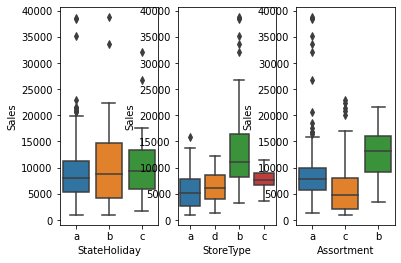

In [14]:
aux = df1[(df1['StateHoliday'] != '0') & (df1['Sales'] > 0)]
plt.subplot( 1, 3, 1 );
sns.boxplot( x='StateHoliday', y='Sales', data=aux );
plt.subplot( 1, 3, 2 );
sns.boxplot( x='StoreType', y='Sales', data=aux );
plt.subplot( 1, 3, 3 );
sns.boxplot( x='Assortment', y='Sales', data=aux );

#Mapa Mental de Hipóteses

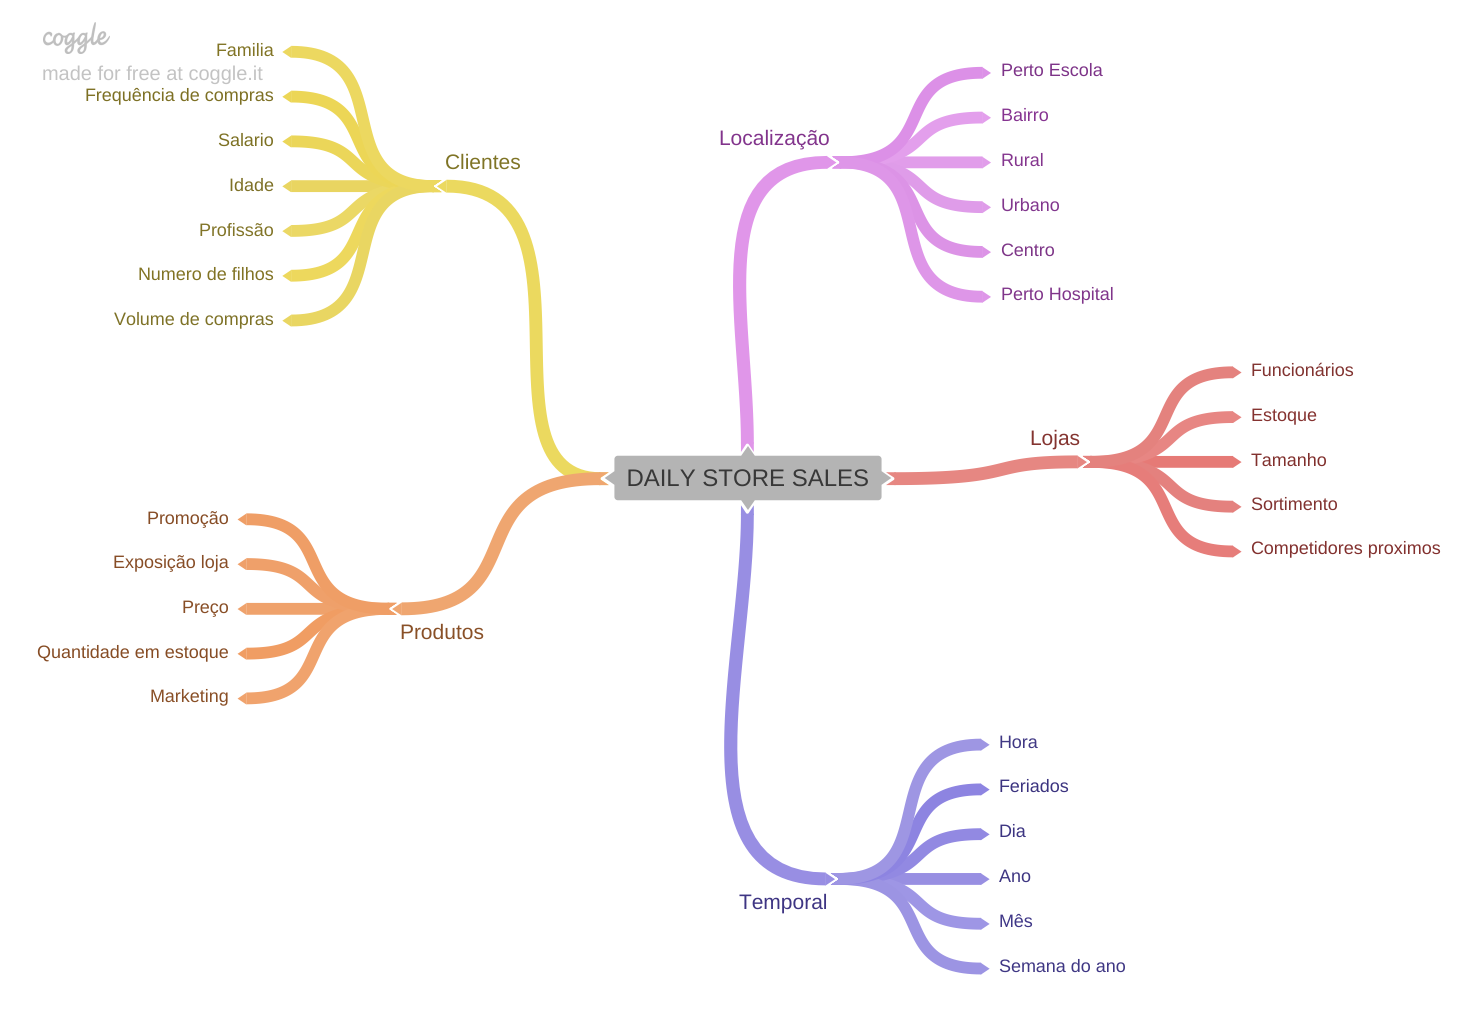

In [15]:
Image('/content/drive/MyDrive/Projetos Pessoais/comunidade ds/projeto rossmann/imagens/mindmap.png')


##Criação de Hipóteses
- Hipótese de Loja
  1. Lojas com maior quadro de funcionarios deveriam vender mais

  2. Lojas com maior estoque deveriam vender mais

  3. Lojas de maior porte deveriam vender mais

  4. Lojas com maior sortimento deveriam vender mais

  5. Lojas com competidores mais proximos deveriam vender menos

  6. Lojas com competidores a mais tempo deveriam vender mais

* Hipótese Produto
  1. Lojas que investem mais em marketing deveriam vender mais

  2. Lojas que expões mais o produto na vitrine deveriam vender mais

  3. Lojas que tem preços menores nos produtos deveriam vender mais

  4. Lojas com promoções mais agressivas deveriam vender mais

  5. Lojas com promoções ativas por mais tempo deveriam vender mais

  6. Lojas com mais dias de promoção deveriam vender mais

  7. Lojas com mais promoções consecutivas deveriam vender mais

* Hipótese Tempo
  1. Lojas abertas durante o feriado de Natal deveriam vender mais

  2. Lojas deveriam vender mais ao longo dos anos

  3. Lojas deveriam vender mais no segundo semestre do ano

  4. Lojas vender mais depois do dia 10 de cada mês

  5. Lojas deveriam vender menos em finais de semana

  6. Lojas deveriam vender menos durante os feriados escolares

- Lista Final de Hipóteses
  1. Lojas com maior sortimento deveriam vender mais

  2. Lojas com competidores mais proximos deveriam vender menos

  3. Lojas com competidores a mais tempo deveriam vender mais

  4. Lojas com promoções ativas por mais tempo deveriam vender mais

  5. Lojas com mais dias de promoção deveriam vender mais

  6. Lojas com mais promoções consecutivas deveriam vender mais

  7. Lojas abertas durante o feriado de Natal deveriam vender mais

  8. Lojas deveriam vender mais ao longo dos anos

  9. Lojas deveriam vender mais no segundo semestre do ano

  10. Lojas vender mais depois do dia 10 de cada mês

  11. Lojas deveriam vender menos em finais de semana

  12. Lojas deveriam vender menos durante os feriados escolares

#Feature Engenering

In [16]:
df2 = df1.copy()

In [17]:
# year
df2['year'] = df2['Date'].dt.year

# month
df2['month'] = df2['Date'].dt.month

# day
df2['day'] = df2['Date'].dt.day

# week of year
df2['week_of_year'] = df2['Date'].dt.isocalendar().week

# year_week
df2['year_week'] = df2['Date'].dt.strftime('%Y-%W')

# competition since
df2['CompetitionSince'] = df2.apply(lambda x: datetime.datetime(year=x['CompetitionOpenSinceYear'], month=x['CompetitionOpenSinceMonth'], day=1), axis=1)
df2['CompetitionTimeMonth'] =  ((df2['Date'] - df2['CompetitionSince'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['PromoSince'] = df2['Promo2SinceYear'].astype(str) + '-' + df2['Promo2SinceWeek'].astype(str)
df2['PromoSince'] = df2['PromoSince'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['PromoTimeEeek'] = ((df2['Date'] - df2['PromoSince'])/7).apply(lambda x: x.days).astype(int)

# assortment 
df2['Assortment'] = df2['Assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['StateHoliday'] = df2['StateHoliday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day') 

# Filtragem de Linhas


In [18]:
df3 = df2.copy()

In [19]:
#filtra pelas vendas cujo as lojas estavam abertas
df3 = df3.loc[(df3['Open'] != 0)  & (df3['Sales'] > 0)]

## Seleção de Colunas

In [20]:
#'customers' - não está disponivel na hora da predição
cols_drop = ['Customers', 'Open', 'PromoInterval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

#Análise Explorativa dos Dados
---
Esta etapa serve para medir o impacto das outras variáveis em relação a variável resposta que normalmente é conhecida como: classe, label ou target

In [21]:
df4= df3.copy()

##Análise Univariada
---

### Response Variable

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


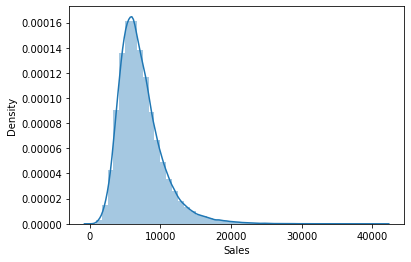

In [22]:
sns.distplot( df4['Sales'], kde=True  );


###Variáveis Numéricas

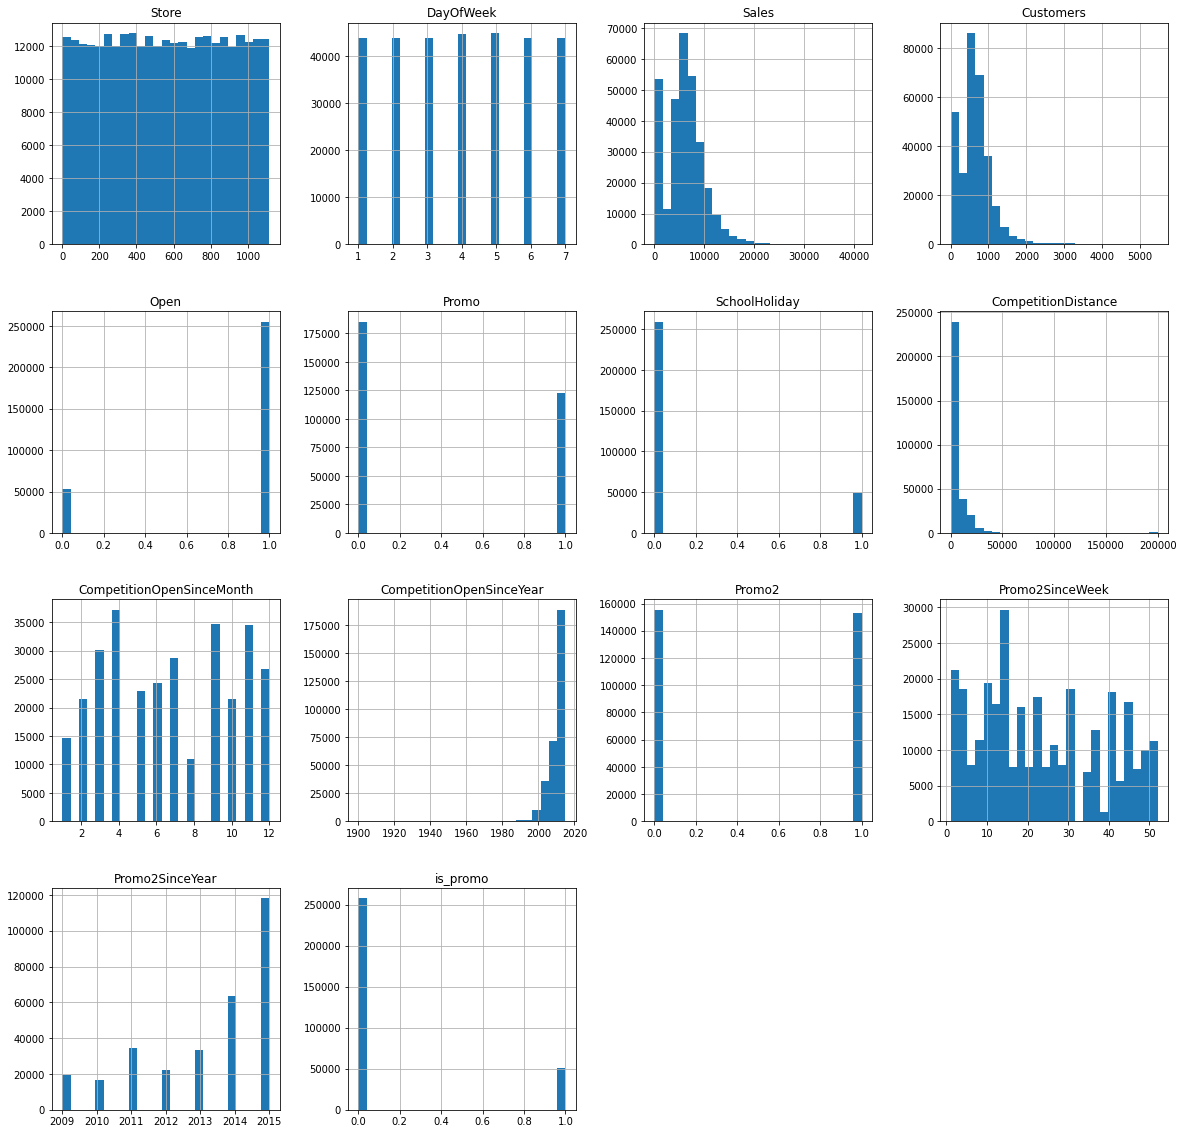

In [23]:
num_attributes.hist(bins=25,figsize=(20,20));

###Variável Categórica

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


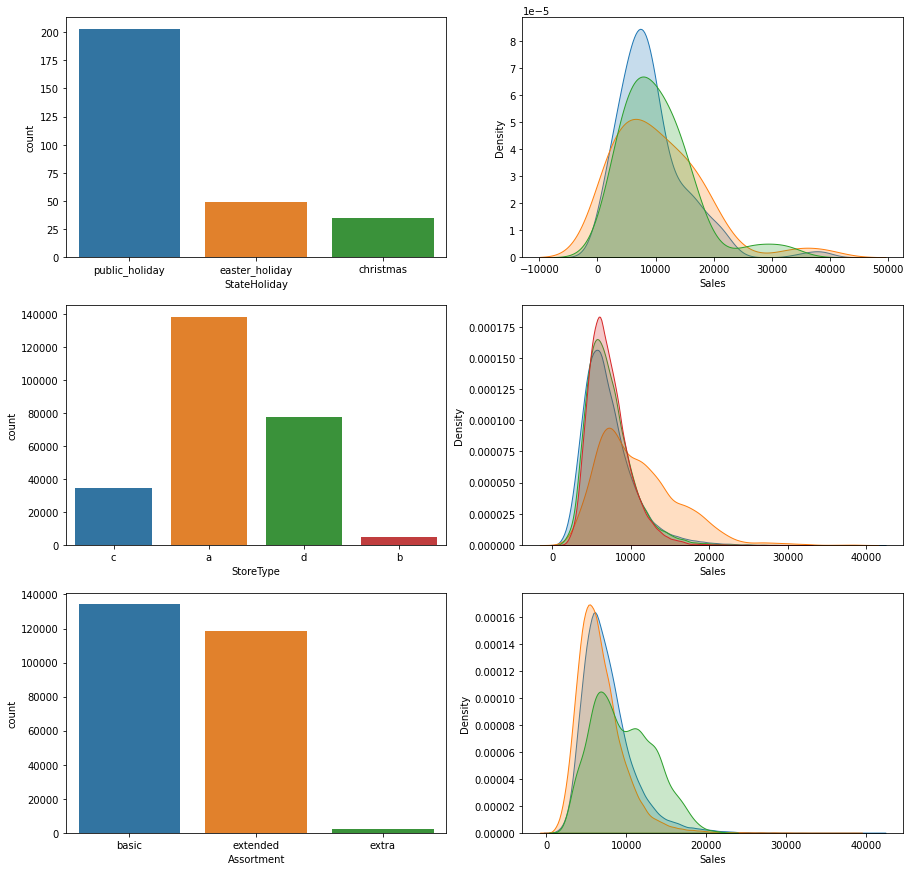

In [24]:
# state_holiday
plt.figure(figsize=(15,15))

plt.subplot( 3, 2, 1 );
a = df4[df4['StateHoliday'] != 'regular_day']
sns.countplot( a['StateHoliday'] );

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['StateHoliday'] == 'public_holiday']['Sales'], label='public_holiday', shade=True );
sns.kdeplot( df4[df4['StateHoliday'] == 'easter_holiday']['Sales'], label='easter_holiday', shade=True );
sns.kdeplot( df4[df4['StateHoliday'] == 'christmas']['Sales'], label='christmas', shade=True );

# store_type
plt.subplot( 3, 2, 3 );
sns.countplot( df4['StoreType'] );

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['StoreType'] == 'a']['Sales'], label='a', shade=True);
sns.kdeplot( df4[df4['StoreType'] == 'b']['Sales'], label='b', shade=True );
sns.kdeplot( df4[df4['StoreType'] == 'c']['Sales'], label='c', shade=True );
sns.kdeplot( df4[df4['StoreType'] == 'd']['Sales'], label='d', shade=True );

# assortment
plt.subplot( 3, 2, 5 );
sns.countplot( df4['Assortment'] );

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['Assortment'] == 'extended']['Sales'], label='extended', shade=True );
sns.kdeplot( df4[df4['Assortment'] == 'basic']['Sales'], label='basic', shade=True );
sns.kdeplot( df4[df4['Assortment'] == 'extra']['Sales'], label='extra', shade=True );


##Análise Bivariada

###H1. Lojas com maior sortimentos deveriam vender mais.
Ou seja, loja com maior previsão de vendas deveriam vender mais?

**FALSA** Lojas com maior sortimento vendem menos

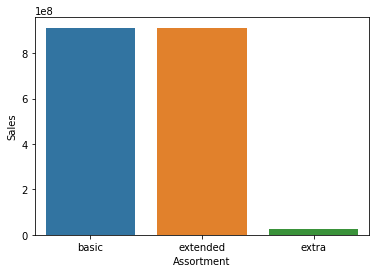

In [25]:
aux1= df4[['Assortment', 'Sales']].groupby( 'Assortment' ).sum().reset_index()
sns.barplot(x='Assortment',y='Sales', data=aux1);

é interessante investigar se o sortimento do tipo extra em algum ponto do passado vendeu mais e por algum motivo vendem menos e por este motivo a soma acumulada apareceu muito baixa

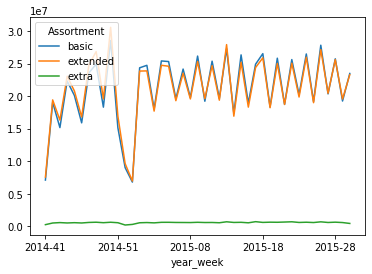

In [26]:
aux2 = df4[['year_week', 'Assortment', 'Sales']].groupby( ['year_week','Assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='Assortment', values='Sales' ).plot();

de acordo com o gráfico acima, podemos ver que basic e extended é muito semelhante e que o extra é muito pequeno, pois o volume dos outros tipos de assortment é tão grande que  extra fica tão pequeno

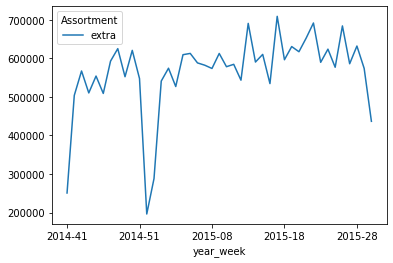

In [27]:
aux3 = aux2[aux2['Assortment'] == 'extra']
aux3.pivot( index='year_week', columns='Assortment', values='Sales' ).plot();

###H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** lojas com competidores mais próximos vendem **mais**

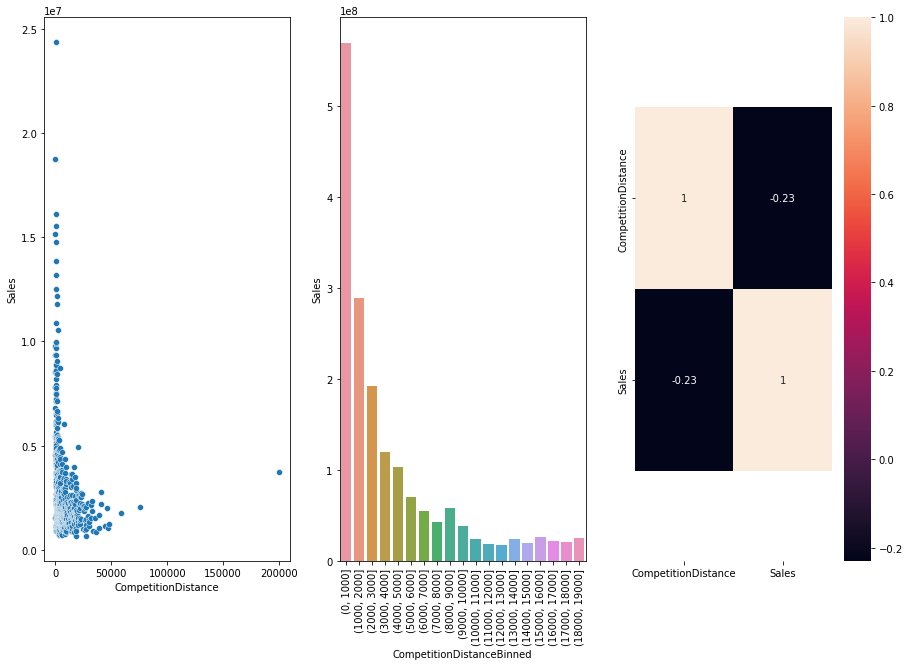

In [28]:
plt.figure(figsize=(15,10))
aux1 = df4[['CompetitionDistance', 'Sales']].groupby('CompetitionDistance').sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='CompetitionDistance', y='Sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['CompetitionDistanceBinned'] = pd.cut( aux1['CompetitionDistance'], bins=bins )
aux2 = aux1[['CompetitionDistanceBinned', 'Sales']].groupby( 'CompetitionDistanceBinned' ).sum().reset_index()
sns.barplot( x='CompetitionDistanceBinned', y='Sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

In [29]:
df4.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'CompetitionSince',
       'CompetitionTimeMonth', 'PromoSince', 'PromoTimeEeek'],
      dtype='object')

###H3. Lojas com competidores à mais tempo deveriam vendem mais.

**FALSO** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.



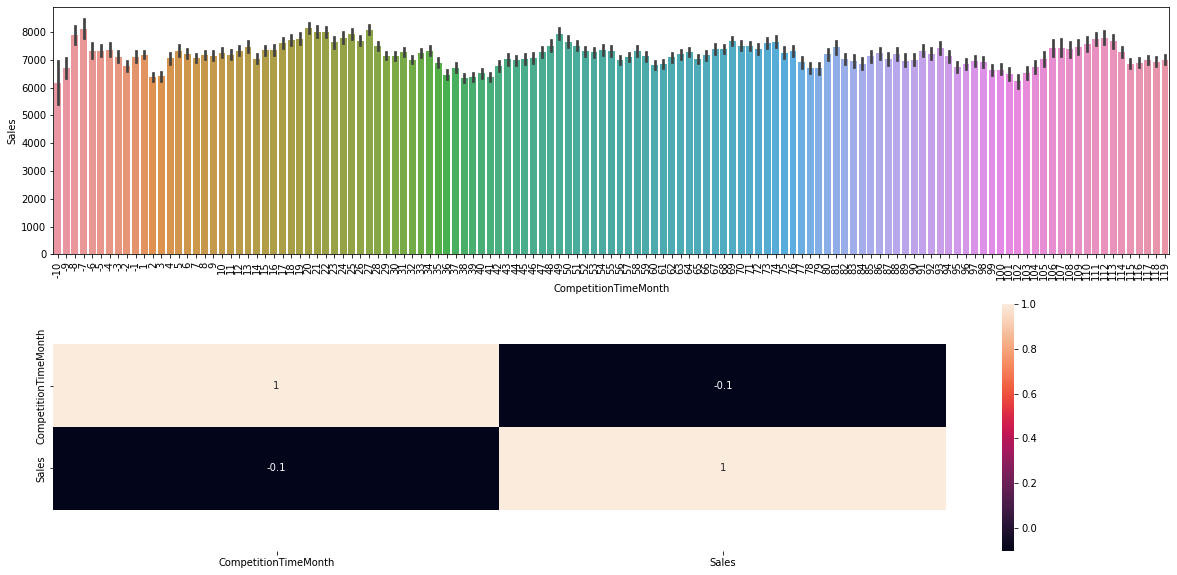

In [30]:
plt.figure(figsize=(20,10))
plt.subplot(2,1, 1)
aux1= df4[['CompetitionTimeMonth', 'Sales']].groupby('CompetitionTimeMonth').sum().reset_index()
aux2 = df4[(df4['CompetitionTimeMonth']<120) & (df4['CompetitionTimeMonth']!=0)]#analisa os 120 primeiros meses da venda em que o competido abriu no mesmo mês da venda
sns.barplot( x='CompetitionTimeMonth', y='Sales', data=aux2 );
plt.xticks( rotation=90 );


plt.subplot( 2, 1, 2)
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

O gráfico acima mostra que quanto mais recente é a competição maior é a venda

###H4. Lojas com promoções ativas por mais tempo deveriam vender mais.¶


###H5. Lojas com mais promoções consecutivas deveriam vender mais.


###H8. Lojas abertas durante o feriado de Natal deveriam vender mais.


##Análise Multi-variada
Irá saber a correlação entre as variáveis e que sao correlacionadas e podendo ser retiradas para diminuir a dimensionalidade e complexidade do modelo

Variáveis Numéricas 

<Figure size 1080x1080 with 0 Axes>

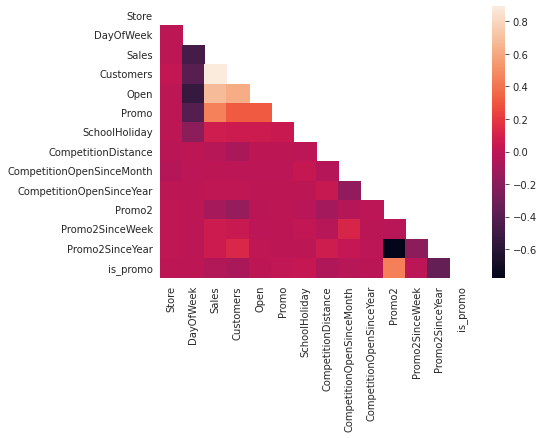

In [31]:
plt.figure(figsize=(15,15))

correlation = num_attributes.corr( method='pearson' )

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(correlation)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(correlation, mask=mask);
#sns.heatmap( correlation, annot=True, linewidths=.5,  vmax=.3, square=True);

Variáveis Categóricas

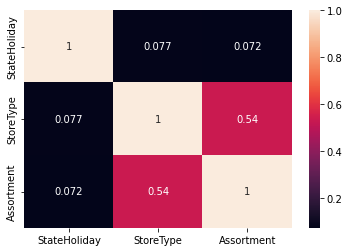

In [32]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['StateHoliday'], a['StateHoliday'] )
a2 = cramer_v( a['StateHoliday'], a['StoreType'] )
a3 = cramer_v( a['StateHoliday'], a['Assortment'] )

a4 = cramer_v( a['StoreType'], a['StateHoliday'] )
a5 = cramer_v( a['StoreType'], a['StoreType'] )
a6 = cramer_v( a['StoreType'], a['Assortment'] )

a7 = cramer_v( a['Assortment'], a['StateHoliday'] )
a8 = cramer_v( a['Assortment'], a['StoreType'] )
a9 = cramer_v( a['Assortment'], a['Assortment'] )

# Final dataset
d = pd.DataFrame( {'StateHoliday': [a1, a2, a3], 
               'StoreType': [a4, a5, a6],
               'Assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

# Preparação dos Dados

In [33]:
df5 = df4.copy()

##Reescala

In [34]:
# competition distance
rs = RobustScaler()
mms = MinMaxScaler()
# fit transform acha os quartis da formula 1ro e 3ro da coluna e ja os aplica
df5['CompetitionDistance'] = rs.fit_transform( df5[['CompetitionDistance']].values )

# competition time month
df5['CompetitionTimeMonth'] = rs.fit_transform( df5[['CompetitionTimeMonth']].values )

# promo time week
df5['PromoTimeEeek'] = mms.fit_transform( df5[['PromoTimeEeek']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )


##Mudança da Variável Categórica para Numérica

In [35]:
# variaveis categoricas

# state_holiday - one hot encoding
#prefix eh o nome que vai ficar na frente da coluna
df5=pd.get_dummies(df5,prefix=['StateHoliday'],columns=['StateHoliday'])


# store_type - Label Encoding
le=LabelEncoder()
df5['StoreType']=le.fit_transform(df5['StoreType'])

# assortment - ordinal encoding
assortment_dict={'basic':1, 'extra':2 , 'extended':3}
#map faz a substituicao da  string para o numero
df5['Assortment']=df5['Assortment'].map(assortment_dict)

##Transformação

In [37]:
df5['Sales'] = np.log1p( df5['Sales'] )#deixa a variável resposta mais proximo de uma normal


###Transformação de Natureza Cíclica


In [41]:
# day of week
df5['DayOfWeek'] = df5['DayOfWeek'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['DayOfWeek'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )